<a href="https://colab.research.google.com/github/pablocaron/teaching_fem/blob/main/fe_bar_example_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup & definition of functions

In the following lines we import the packages to do the numerical calculations and the plots.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Custom functions for this notebook.

In [2]:
def Kbarra2D(E,A,x0,x1,y0,y1):
  """Function to calculate the stiffness matrix for a two dimensional bar element with constant properties.
  
  Kbarra2D(E,A,x0,x1,y0,y1):
  E:     Young's modulus
  A:     Element's area
  x0: First node's x coordinate
  y0: First node's y coordinate
  x1: Second node's x coordinate
  y1: Second node's y coordinate
  """
  L=np.sqrt((x1-x0)**2+(y1-y0)**2)     # Length of the element
  c=  (x1-x0)/L                        # cosine(beta) where beta is the angle between the axis of the element and the x axis
  s=  (y1-y0)/L                        # sine(beta)   where beta is the angle between the axis of the element and the x axis
  c2= c**2                             # squared cosine(beta)
  s2= s**2                             # squared sine(beta)
  cs= c*s                              # product between cosine(beta) and sine(beta)
  return np.array([[c2,cs,-c2,-cs],[cs,s2,-cs,-s2],[-c2,-cs,c2,cs],[-cs,-s2,cs,s2]])*(E*A)/L

#def Fctebarra1D(q,L):                  # This function must be adapted to the 2D bar
#  return np.array([[q*L/2],[q*L/2]])

def assembleK(klocal,kglobal,conec):
  """
  Function to assemble the local matrix klocal into the kglobal matrix following the conectivity conec

  This function assumes that the matrices have the correct dimensions.
  klocal:  Local matrix of the assembled element
  kglobal: Global matrix
  conec:   conectivity matrix for the assembled element
  """
  klocalsize=np.shape(klocal)
  for i in range(klocalsize[1]):
    for j in range(klocalsize[1]):
      kglobal[conec[i],conec[j]]+=klocal[i,j]
  return kglobal

def assembleF(flocal,fglobal,conec):
  """
  Function to assemble the local vector flocal into the global vector fglobal following the conectivity conec

  This function assumes that the matrices have the correct dimensions.
  flocal:  Local vector of the assembled element
  fglobal: Global vector
  conec:   conectivity matrix for the assembled element
  """
  flocalsize=np.shape(flocal)
  for i in range(flocalsize[0]):
    fglobal[conec[i]]+=flocal[i,0]
  return fglobal

# Problem to solve

## Material and geometrical properties
The three elements have the same properties which are listed below:

In [3]:
Eyoung=210000                                  # Young modulus [N/mm^2]
De=12.7                                        # External diameter of the bar [mm]
Di=10.7                                        # Internal diameter of the bar [mm]
A=np.pi*(De**2-Di**2)/4                        # Bar's area
print("The are of the bar is %.2f [mm^2]"% A)  # Print the Bar's area for further use
P=-1000                                        # External applied load [N]
beta=30                                        # Angle of the support at node 2
a=np.tan(30*np.pi/180)                         # Slope of the support at node 2

The are of the bar is 36.76 [mm^2]


## Topological description
The coordinates of the nodes are stored in the following array:

In [4]:
coord=np.array([[0,0],[1000,0],[500,700]])

The conectivity of each elements is stored in the following array

In [5]:
conectivity=np.array([[0,1,2,3],[2,3,4,5],[4,5,0,1]])

# Solution

## Global problem to solve

First we create the stiffness matrix for each element

In [6]:
k0=Kbarra2D(Eyoung,A,coord[0,0],coord[1,0],coord[0,1],coord[1,1])
k1=Kbarra2D(Eyoung,A,coord[1,0],coord[2,0],coord[1,1],coord[2,1])
k2=Kbarra2D(Eyoung,A,coord[2,0],coord[0,0],coord[2,1],coord[0,1])

Second we assemble these matrices into the global stiffness matrix

In [7]:
Ndof=np.max(conectivity)+1            # This is the number of degrees of freedom in the system.
KG=np.zeros([Ndof,Ndof])              # Initialize the global stiffness matrix with zeros

KG=assembleK(k0,KG,conectivity[0])    # Assemble the first element in the global matrix
KG=assembleK(k1,KG,conectivity[1])    # Assemble the second element in the global matrix
KG=assembleK(k2,KG,conectivity[2])    # Assemble the third element in the global matrix
#print(KG)                             # This is to check the global matrix

The vector of the applied loads is the following:

(For simplicity is filled *by hand*)

In [8]:
FG=np.array([[0],[0],[0],[0],[0],[P]])
#print(FG)                               # This is to check the global vector

## Apply the restriction to node 1

NOTE: The following strategy to include the restrictions follows the NASTRAN theoretical manual SP-221.

The displacements in this node are $u_2$ and $u_3$ and they are related in a way that a combination of them produce slip in the desired direction.

In the present problem we chose the $u_3$ as the *dependent* 

The list of dependent an independent displacement are idenfied as *m* and *n*, respectively

In [9]:
dofm=[3]                   # Degrees of freedom chosen as dependent 
dofn=[0,1,2,4,5]           # Degrees of freedom chosen as inddependent 

In [10]:
Knn=KG[np.ix_(dofn,dofn)]  # Submatrix extraction for the independent dof
Knm=KG[np.ix_(dofn,dofm)]  # Submatrix extraction for the mixed dof
Kmm=KG[np.ix_(dofm,dofm)]  # Submatrix extraction for the dependent dof
Pn=FG[np.ix_(dofn,[0])]    # Subvector extraction for the independent dof
Pm=FG[np.ix_(dofm,[0])]    # Subvector extraction for the dependent dof

The restriction between DOF (displacements) 2 and 3 can be writen as:
\begin{equation*}
 u_3 - a\ u_2=0
\end{equation*}
where $a$ is the slope of the line which define the slip direction in node 1

This expression can be rewriten using the global dof

\begin{equation*}
 \underbrace{
 \begin{bmatrix}
  0 & 0 & -a & 1 & 0 & 0
 \end{bmatrix}}_{[R]}
 \begin{Bmatrix}
  u_0\\u_1\\u_2\\u_3\\u_4\\u_5
 \end{Bmatrix}
 = 0
\end{equation*}
Then, we divide the system in the dependent and independent parts as:
\begin{equation*}
 \underbrace{
 \begin{bmatrix}
  0 & 0 & -a & 0 & 0
 \end{bmatrix}}_{[R_n]}
 \begin{Bmatrix}
  u_0\\ u_1\\ u_2\\ u_4\\ u_5\\
 \end{Bmatrix}
 +
 \underbrace{
 \begin{bmatrix}
  1
 \end{bmatrix}}_{[R_m]}
 \begin{Bmatrix}
  u_3
 \end{Bmatrix}
 =0
\end{equation*}
Again, and to resemble the expresions found in the NASTRAN theoretical manual, we find the matrix $[G_m]$
\begin{align*}
 [G_m]&=-[R_m]^{-1}[R_n]\\
 [G_m]&=-\frac{1}{1}\begin{bmatrix}
  0 & 0 & -a & 0 & 0
 \end{bmatrix}\\
 [G_m]&=\begin{bmatrix}
  0 & 0 & a & 0 & 0
 \end{bmatrix}
\end{align*}

The matrix $[G_m]$ is then

In [11]:
Gm=np.array([[0,0,a,0,0]])
#print(Gm)

We also define the $[R]$ matrix for further use

In [12]:
Rm=np.array([[0,0,-a,1,0,0]])

Then, the system of equations which include the restrictions are
\begin{equation*}
 \left([K_{nn}] +[K_{nm}][G_m]+[G_m]^T[K_{nm}]^T+[G_m]^T[K_{mm}][G_m]\right)
 \{ u_n\}=\{P_n\}+[G_m]^T{P_m}
\end{equation*}
where
\begin{equation*}
\{u_n\}=
\begin{Bmatrix}
 u_0\\ u_1 \\ u_2 \\ u_4 \\ u_5
 \end{Bmatrix}
\end{equation*}
and we define the *reduced* matrices and vectors as
\begin{align*}
 [K^r]&=[K_{nn}] +[K_{nm}][G_m]+[G_m]^T[K_{nm}]^T+[G_m]^T[K_{mm}][G_m] \\
 \{P^r\}&=\{P_n\}+[G_m]^T{P_m}
\end{align*}

In [13]:
Kr=Knn+np.matmul(Knm,Gm)+np.matmul(np.transpose(Gm),np.transpose(Knm))+np.matmul(np.matmul(np.transpose(Gm),Kmm),Gm)
#print(Kr)

In [14]:
Pr=Pn+np.matmul(np.transpose(Gm),Pm)
#print(Pr)

## Solution of the reduced system
To solve the reduced system of equation we must include the boundary conditions to the DOFs $u_0$ and $u_1$.

The procedure follows the usual strategy that we use in the problems with degrees of freedom constrained aligned with the coordinates system.

First we define the set of dof to be eliminated from the system $s$ and which will not be eliminated $f$.

In [15]:
dofs=[0,1]
doff=[2,3,4]

In [16]:
Kss=Kr[np.ix_(dofs,dofs)]
Ksf=Kr[np.ix_(dofs,doff)]
Kfs=Kr[np.ix_(doff,dofs)]
Kff=Kr[np.ix_(doff,doff)]
Ps=Pr[np.ix_(dofs,[0])]
Pf=Pr[np.ix_(doff,[0])]

The solution for the $f$ set of degrees of freedom is

In [17]:
uf=np.matmul(np.linalg.inv(Kff),Pf)
print(uf)

[[ 0.00887015]
 [ 0.00085025]
 [-0.08475971]]


We now can reconstruct the set of *independent* degrees of freedom

In [18]:
usf=np.zeros([5,1])           # Create a array to store the free degrees of freedom
usf[doff]=uf                  # Store the f set of degrees of freedom
print(usf)

[[ 0.        ]
 [ 0.        ]
 [ 0.00887015]
 [ 0.00085025]
 [-0.08475971]]


The reaction at the $s$ set of degrees of freedom are

In [19]:
qs=-Ps+np.matmul(np.transpose(Kfs),uf)
print(qs)

[[288.67513459]
 [500.        ]]


## Solution for the dependent DOF
From the previous dependent set of degrees of freedom ($u_{sf}$) we can recover the solution for the *dependent* degree of freedom

In [20]:
um=np.matmul(Gm,usf)
print(um)

[[0.00512118]]


Also, we can find the reaction at the *dependent* degree of freedom

In [21]:
qm=-Pm+np.matmul(np.transpose(Knm),usf)+np.matmul(np.matmul(Kmm,Gm),usf)
print(qm)

[[500.]]


## Complet solution
We can now write the complete vector of degrees of freedom

In [22]:
desp=np.zeros([Ndof,1])        # Create vector with zeros to store the complete solution

In [23]:
desp[dofn]=usf                 # Store the independent degrees of freedom
desp[dofm]=um                  # Store the dependent degrees of freedom
print(desp)

[[ 0.        ]
 [ 0.        ]
 [ 0.00887015]
 [ 0.00512118]
 [ 0.00085025]
 [-0.08475971]]


## Plot the results

<function matplotlib.pyplot.show>

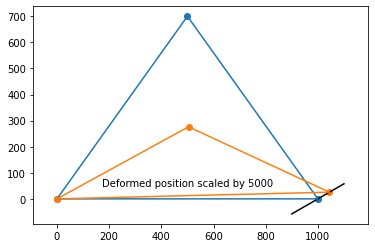

In [24]:
xOrig=coord[:,0]                                             # Extract the x coordinates from the coordinates data
yOrig=coord[:,1]                                             # Extract the y coordinates from the coordinates data
scale=5000                                                   # Scale factor to enlarge the results
xDef=coord[:,0]+desp[[0,2,4],0]*scale                        # Deformed x position of the nodes
yDef=coord[:,1]+desp[[1,3,5],0]*scale                        # Deformed y position of the nodes

xSupport=np.array([coord[1,0]*0.9,coord[1,0],coord[1,0]*1.1])        # Vector to draw the support at node 2 (x coordinate) 
ySupport=np.array([coord[1,0]*(-0.1)*a,coord[1,1],coord[1,0]*0.1*a]) # Vector to draw the support at node 2 (y coordinate) 

plt.plot(xSupport,ySupport,color='black')
xOrigPlt=np.concatenate((xOrig,np.array([xOrig[0]])))        # Include the last point's x coordinate to plot the elements with lines
yOrigPlt=np.concatenate((yOrig,np.array([yOrig[0]])))        # Include the last point's y coordinate to plot the elements with lines
xDefPlt=np.concatenate((xDef,np.array([xDef[0]])))           # Include the last point's x coordinate to plot the elements with lines
yDefPlt=np.concatenate((yDef,np.array([yDef[0]])))           # Include the last point's y coordinate to plot the elements with lines
plt.scatter(xOrig,yOrig)                                     # Plot the nodes at their original positions
plt.scatter(xDef,yDef)                                       # Plot the nodes at their deformed positions
plt.plot(xOrigPlt,yOrigPlt)                                  # Plot the elements (lines) at their original positions
plt.plot(xDefPlt,yDefPlt)                                    # Plot the elements (lines) at their final positions

plt.axis('equal')
plt.text(500, 50, 'Deformed position scaled by %i' % (scale), ha='center')
plt.show                                                     # Show the plot

## Reactions

Reactions at the $s$ set of DOFs

In [25]:
Rtot=np.zeros([Ndof,1])
Rtot[dofs]=Rtot[dofs]+qs
print(Rtot)

[[288.67513459]
 [500.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]]


Reactions at the $m$ set of dependent DOFs

In [26]:
qmtot=np.matmul(np.transpose(Rm),qm)
Rtot+=qmtot
print(Rtot)

[[ 288.67513459]
 [ 500.        ]
 [-288.67513459]
 [ 500.        ]
 [   0.        ]
 [   0.        ]]


We split the previous vectors in each direction

In [27]:
Rtotx=Rtot[[0,2,4]]     # Reactions in the x direction
Rtoty=Rtot[[1,3,5]]     # Reactions in the y direction

In [28]:
FGx=FG[[0,2,4]]         # Applied forces the x direction
FGy=FG[[1,3,5]]         # Applied forces the y direction

We check the sum of forces in each direction

In [29]:
np.sum(Rtotx+FGx)      # Sum of forces in the x direction

0.0

In [30]:
np.sum(Rtoty+FGy)      # Sum of forces in the y direction

0.0